In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
import random
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from pandas import DataFrame, Series
from patsy import dmatrices
from scipy import stats
from sklearn import metrics
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             confusion_matrix, ConfusionMatrixDisplay, 
                             average_precision_score, balanced_accuracy_score, 
                             matthews_corrcoef, roc_auc_score)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance



In [2]:
percentages_url = 'https://api.nhle.com/stats/rest/en/skater/percentages?limit=-1&cayenneExp=seasonId=20232024'
percentages_resp = requests.get(percentages_url)
percentages_json = percentages_resp.json()

In [3]:
df_percentages = DataFrame(percentages_json['data'])
df_percentages_filtered = df_percentages.loc[(df_percentages['positionCode'] != 'D') & (df_percentages['gamesPlayed'] >= 20)]
df_percentages_filtered = df_percentages_filtered.reset_index(drop=True)
df_percentages_filtered.drop(['skaterSavePct5v5', 'seasonId','shootingPct5v5', 'timeOnIcePerGame5v5', 'zoneStartPct5v5', 'satPercentage', 'satPercentageBehind', 'satPercentageAhead', 'satRelative', 'skaterShootingPlusSavePct5v5', 'usatPercentage', 'usatPercentageAhead', 'usatPercentageBehind', 'usatRelative'], axis=1, inplace=True)
df_percentages_filtered = df_percentages_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches','satPercentageClose',
 'satPercentageTied','usatPercentageTied', 'usatPrecentageClose']]

In [4]:
df_percentages_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,usatPrecentageClose
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,0.464,0.436,0.401,0.436
1,8475763,Kevin Hayes,Hayes,R,STL,79,L,0.450,0.443,0.430,0.436
2,8471698,T.J. Oshie,Oshie,R,WSH,56,R,0.433,0.416,0.411,0.431
3,8482259,Bobby McMann,McMann,C,TOR,56,L,0.523,0.518,0.509,0.530
4,8480748,Kiefer Sherwood,Sherwood,L,NSH,74,R,0.520,0.535,0.534,0.522
...,...,...,...,...,...,...,...,...,...,...,...
469,8482125,Alexander Holtz,Holtz,R,NJD,82,R,0.467,0.447,0.437,0.456
470,8479367,William Lockwood,Lockwood,R,FLA,26,R,0.554,0.531,0.485,0.530
471,8480068,Ryan Poehling,Poehling,C,PHI,77,L,0.484,0.448,0.497,0.524
472,8478477,Mitchell Stephens,Stephens,C,MTL,23,R,0.412,0.444,0.493,0.444


In [5]:
summary_url = 'https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId=20232024'
summary_resp = requests.get(summary_url)
summary_json = summary_resp.json()

In [6]:
df_summary = DataFrame(summary_json['data'])
df_summary_filtered = df_summary.loc[(df_summary['positionCode'] != 'D') & (df_summary['gamesPlayed'] >= 20)]
df_summary_filtered = df_summary_filtered.reset_index(drop=True)
df_summary_filtered.drop(['assists', 'evGoals', 'evPoints', 'faceoffWinPct', 'goals', 'penaltyMinutes', 'plusMinus', 'points', 'pointsPerGame', 'ppGoals', 'ppPoints', 'shPoints','shootingPct', 'shootsCatches', 'shots', 'timeOnIcePerGame', 'seasonId'], axis=1, inplace=True)
df_summary_filtered = df_summary_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'gameWinningGoals','otGoals', 'shGoals']]

In [7]:
df_summary_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,gameWinningGoals,otGoals,shGoals
0,8480039,Martin Necas,Necas,C,CAR,88,3,2,0
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,1,0,0
2,8475763,Kevin Hayes,Hayes,R,STL,79,2,0,0
3,8471698,T.J. Oshie,Oshie,R,WSH,56,4,0,0
4,8482259,Bobby McMann,McMann,C,TOR,56,0,0,0
...,...,...,...,...,...,...,...,...,...
469,8476483,Rickard Rakell,Rakell,R,PIT,70,2,0,0
470,8474715,Cameron Atkinson,Atkinson,R,PHI,70,3,0,0
471,8479367,William Lockwood,Lockwood,R,FLA,26,0,0,0
472,8480068,Ryan Poehling,Poehling,C,PHI,77,1,0,3


In [8]:
df_players_merged = pd.merge(df_percentages_filtered, df_summary_filtered, on = 'playerId')
df_players_merged.drop(['skaterFullName_y', 'lastName_y', 'positionCode_y', 'teamAbbrevs_y', 'gamesPlayed_y'], axis=1, inplace=True)
df_players_merged.columns = ['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']
df_players_merged = df_players_merged[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']]

In [9]:
percentages  = ['satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose']

for stat in percentages:
    df_players_merged[stat] *= 100

df_players_merged['teamAbbrevs'] = df_players_merged['teamAbbrevs'].apply(lambda x: x.split(',')[0].strip() if ',' in x else x)

In [10]:
def headshot(row):
    headshot_link = 'https://assets.nhle.com/mugs/nhl/20232024/' + str(row['teamAbbrevs']) + '/' + str(row['playerId']) + '.png'
    return headshot_link

df_players_merged['headshot'] = df_players_merged.apply(headshot, axis=1)

In [11]:
def logo(row):
    logo_link = 'https://assets.nhle.com/logos/nhl/svg/' + str(row['teamAbbrevs']) + '_dark.svg'
    return logo_link

df_players_merged['logo'] = df_players_merged.apply(logo, axis=1)

In [12]:
columns = ['satPercentageClose', 'satPercentageTied', 'usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals']

def percentile(row, column):
    percentile_score = stats.percentileofscore(df_players_merged[column], row[column])
    return percentile_score

for column in columns:
    df_players_merged[column + 'Percentile'] = df_players_merged.apply(lambda row: percentile(row, column), axis = 1)
    df_players_merged[column + 'Percentile'] = df_players_merged[column + 'Percentile'].round(2)

df_players_merged['tiedPercentile'] =  ((df_players_merged['satPercentageTiedPercentile'] + df_players_merged['usatPercentageTiedPercentile']) / 2).round(2)
df_players_merged['closePercentile'] = ((df_players_merged['usatPercentageClosePercentile'] + df_players_merged['satPercentageClosePercentile']) / 2).round(2)
df_players_merged['final'] = (0.3 * df_players_merged['tiedPercentile'] + 0.3 * df_players_merged['closePercentile'] + 0.4 * df_players_merged['gameWinningGoalsPercentile']).round(2)
df_players_merged['finalRank'] = df_players_merged['final'].rank(ascending=False)

In [13]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,...,logo,satPercentageClosePercentile,satPercentageTiedPercentile,usatPercentageTiedPercentile,usatPercentageClosePercentile,gameWinningGoalsPercentile,tiedPercentile,closePercentile,final,finalRank
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,46.4,43.6,40.1,...,https://assets.nhle.com/logos/nhl/svg/COL_dark...,27.94,15.13,3.99,13.76,36.97,9.56,20.85,23.91,399.0
1,8475763,Kevin Hayes,Hayes,R,STL,79,L,45.0,44.3,43.0,...,https://assets.nhle.com/logos/nhl/svg/STL_dark...,20.48,18.28,13.76,13.76,55.67,16.02,17.12,32.21,355.0
2,8471698,T.J. Oshie,Oshie,R,WSH,56,R,43.3,41.6,41.1,...,https://assets.nhle.com/logos/nhl/svg/WSH_dark...,12.82,8.61,7.25,11.55,80.78,7.93,12.18,38.35,320.0
3,8482259,Bobby McMann,McMann,C,TOR,56,L,52.3,51.8,50.9,...,https://assets.nhle.com/logos/nhl/svg/TOR_dark...,72.90,67.65,59.56,78.36,13.34,63.60,75.63,47.10,267.0
4,8480748,Kiefer Sherwood,Sherwood,L,NSH,74,R,52.0,53.5,53.4,...,https://assets.nhle.com/logos/nhl/svg/NSH_dark...,70.38,78.26,76.16,70.80,55.67,77.21,70.59,66.61,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8482125,Alexander Holtz,Holtz,R,NJD,82,R,46.7,44.7,43.7,...,https://assets.nhle.com/logos/nhl/svg/NJD_dark...,29.73,20.48,16.39,22.37,70.17,18.44,26.05,41.42,301.0
472,8479367,William Lockwood,Lockwood,R,FLA,26,R,55.4,53.1,48.5,...,https://assets.nhle.com/logos/nhl/svg/FLA_dark...,90.86,75.53,41.28,78.36,13.34,58.40,84.61,48.24,258.0
473,8480068,Ryan Poehling,Poehling,C,PHI,77,L,48.4,44.8,49.7,...,https://assets.nhle.com/logos/nhl/svg/PHI_dark...,41.39,21.11,51.79,73.11,36.97,36.45,57.25,42.90,292.0
474,8478477,Mitchell Stephens,Stephens,C,MTL,23,R,41.2,44.4,49.3,...,https://assets.nhle.com/logos/nhl/svg/MTL_dark...,5.15,18.59,47.58,17.12,13.34,33.08,11.14,18.60,418.0


In [14]:
df_players_merged[['satPercentageClose', 'satPercentageTied', 'usatPercentageTied', 'usatPercentageClose']].describe(percentiles=[0.75, 0.8, 0.9])

,satPercentageClose,satPercentageTied,usatPercentageTied,usatPercentageClose
count,476.000000,476.000000,476.000000,476.000000
mean,49.243277,49.294328,49.371849,49.277731
std,4.980063,5.367198,5.360664,4.852625
min,33.100000,34.000000,34.700000,34.400000
50%,49.550000,49.650000,49.600000,49.600000
75%,52.600000,53.025000,53.200000,52.600000
80%,53.100000,53.900000,54.100000,53.100000
90%,54.850000,55.900000,56.000000,54.850000
max,62.700000,62.700000,63.900000,61.500000


In [15]:
df_players_merged[['gameWinningGoals', 'otGoals', 'shGoals']].describe(percentiles=[0.75, 0.8, 0.9])

,gameWinningGoals,otGoals,shGoals
count,476.000000,476.000000,476.000000
mean,2.302521,0.334034,0.462185
std,2.442793,0.704704,0.873371
min,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,3.000000,0.000000,1.000000
80%,4.000000,1.000000,1.000000
90%,5.000000,1.000000,2.000000
max,13.000000,4.000000,6.000000


In [16]:
gameWinningGoalsQuantile = df_players_merged['gameWinningGoals'].quantile(0.8)

def binary_clutchness(row):
    clutchness = (row['satPercentageClose'] >= 55) or (row['satPercentageTied'] >= 55) or (row['usatPercentageClose'] >= 55) or (row['usatPercentageTied'] >= 55) and (row['gameWinningGoals'] >= gameWinningGoalsQuantile)
    if clutchness:
        return 1
    else:
        return 0
        
df_players_merged['clutch_performance'] = df_players_merged.apply(binary_clutchness, axis=1)

In [17]:
df_players_merged['clutch_performance'].value_counts()

clutch_performance
0    394
1     82
Name: count, dtype: int64

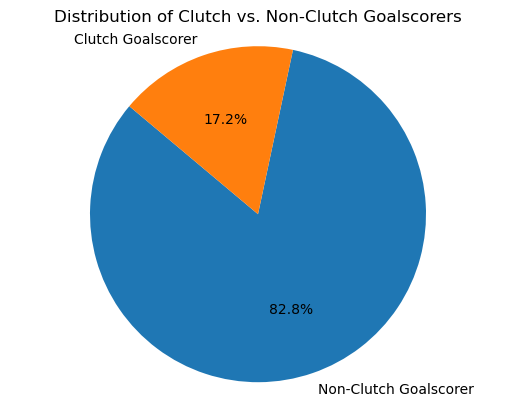

In [18]:
key = ['Non-Clutch Goalscorer', 'Clutch Goalscorer',]

plt.pie(df_players_merged['clutch_performance'].value_counts(), labels=key, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Clutch vs. Non-Clutch Goalscorers')
plt.axis('equal') 
plt.show()

In [19]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = ['clutch_performance']
train, test = train_test_split(df_players_merged, test_size = 0.3)

xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='mlogloss')
xgb_model.fit(train[x_var], train[y_var])

test['xgb_clutch_type'] = xgb_model.predict(test[x_var])
test['xgb_correct'] = (test['xgb_clutch_type'] == test['clutch_performance'])
xgb_accuracy = test['xgb_correct'].mean()
xgb_accuracy

0.972027972027972

In [20]:
'''import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import friedmanchisquare

x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

x = df_players_merged[x_var]
y = df_players_merged[y_var]

models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
}

metrics = {name: {'precision': [], 'recall': [], 'auc_pr': [], 'f1_score': []} for model_name in models}
def evaluate_model(model, x, y):
    precision_scores = []
    recall_scores = []
    auc_pr_scores = []
    f1_scores = []
    
    skf = StratifiedKFold(n_splits = 5)

    for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        model.fit(x_train_fold, y_train_fold)
        y_true = y_test_fold

        y_pred = model.predict(x_test_fold)
        y_pred_proba = model.predict_proba(x_test_fold)[:, 1]
            

        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
        auc_pr_scores.append(average_precision_score(y_true, y_pred_proba))
        f1_scores.append(f1_score(y_true, y_pred))

    return {
        'precision': precision_scores,
        'recall': recall_scores,
        'auc_pr': auc_pr_scores,
        'f1_score': f1_scores
    }


for model_name, model in models.items():
    results = evaluate_model(model, x, y)
    for metric in metrics[model_name]:
        metrics[model_name][metric] = results[metric]

data_for_tests = {
    'precision': [metrics[name]['precision'] for name in models],
    'recall': [metrics[name]['recall'] for name in models],
    'auc_pr': [metrics[name]['auc_pr'] for name in models],
    'f1_score': [metrics[name]['f1_score'] for name in models],
}

for metric, data in data_for_tests.items():
    stat, p = friedmanchisquare(*data)
    print(f'Friedman test for {metric.capitalize()}: statistic={stat}, p-value={p}')''

SyntaxError: incomplete input (1777348547.py, line 1)

In [ ]:
'''for model_name in metrics.keys():
    print(f"{model_name} recall: {metrics[model_name]['recall']}")'''
    

In [ ]:
'''import pandas as pd

# Extract precision scores
precision_data = []

for model_name, metrics_values in metrics.items():
    precision_scores = metrics_values['recall']
    
    for fold_index, score in enumerate(precision_scores):
        precision_data.append({
            'Model': model_name,
            'Fold': fold_index + 1,
            'Precision': score
        })

precision_df = pd.DataFrame(precision_data)

knn_precision = precision_df.loc[precision_df['Model'] == 'KNN', 'Precision'].values
random_forest_precision = precision_df.loc[precision_df['Model'] == 'Random Forest', 'Precision'].values
xgboost_forest_precision = precision_df.loc[precision_df['Model'] == 'XGBoost', 'Precision'].values

res = friedmanchisquare(knn_precision, random_forest_precision, xgboost_forest_precision)
print(res.statistic)
print(res.pvalue)

precision_df['Rank'] = precision_df.groupby('Fold')['Precision'].rank(ascending=False)

rank_sum = precision_df.groupby('Model')['Rank'].sum().reset_index()
rank_sum.columns = ['Model', 'Rank_Sum']
rank_sum['Sum Squared'] = rank_sum['Rank_Sum'] ** 2

chi_square = 12 / (10 * 3 * (3 + 1)) * rank_sum['Sum Squared'].sum() - 3 * 10 * (3 + 1)

print(chi_square)
'''

Friedman test for Precision: statistic=1.0000000000000377, p-value=0.606530659712622
Friedman test for Recall: statistic=14.249999999999972, p-value=0.0008047330101246247

Metrics Summary for Recall (p < 0.05):
                    mean
KNN            0.840000
Random Forest  0.924444
XGBoost        0.935556
                    KNN  Random Forest   XGBoost
KNN            1.000000       0.138024  0.138024
Random Forest  0.138024       1.000000  0.864769
XGBoost        0.138024       0.864769  1.000000
Friedman test for Auc_pr: statistic=8.999999999999986, p-value=0.011108996538242384

Metrics Summary for Auc_pr (p < 0.05):
                    mean
KNN            0.956021
Random Forest  0.994339
XGBoost        0.989159
                    KNN  Random Forest   XGBoost
KNN            1.000000       0.084241  0.130622
Random Forest  0.084241       1.000000  0.704198
XGBoost        0.130622       0.704198  1.000000
Friedman test for F1_score: statistic=11.352941176470596, p-value=0.00342562758

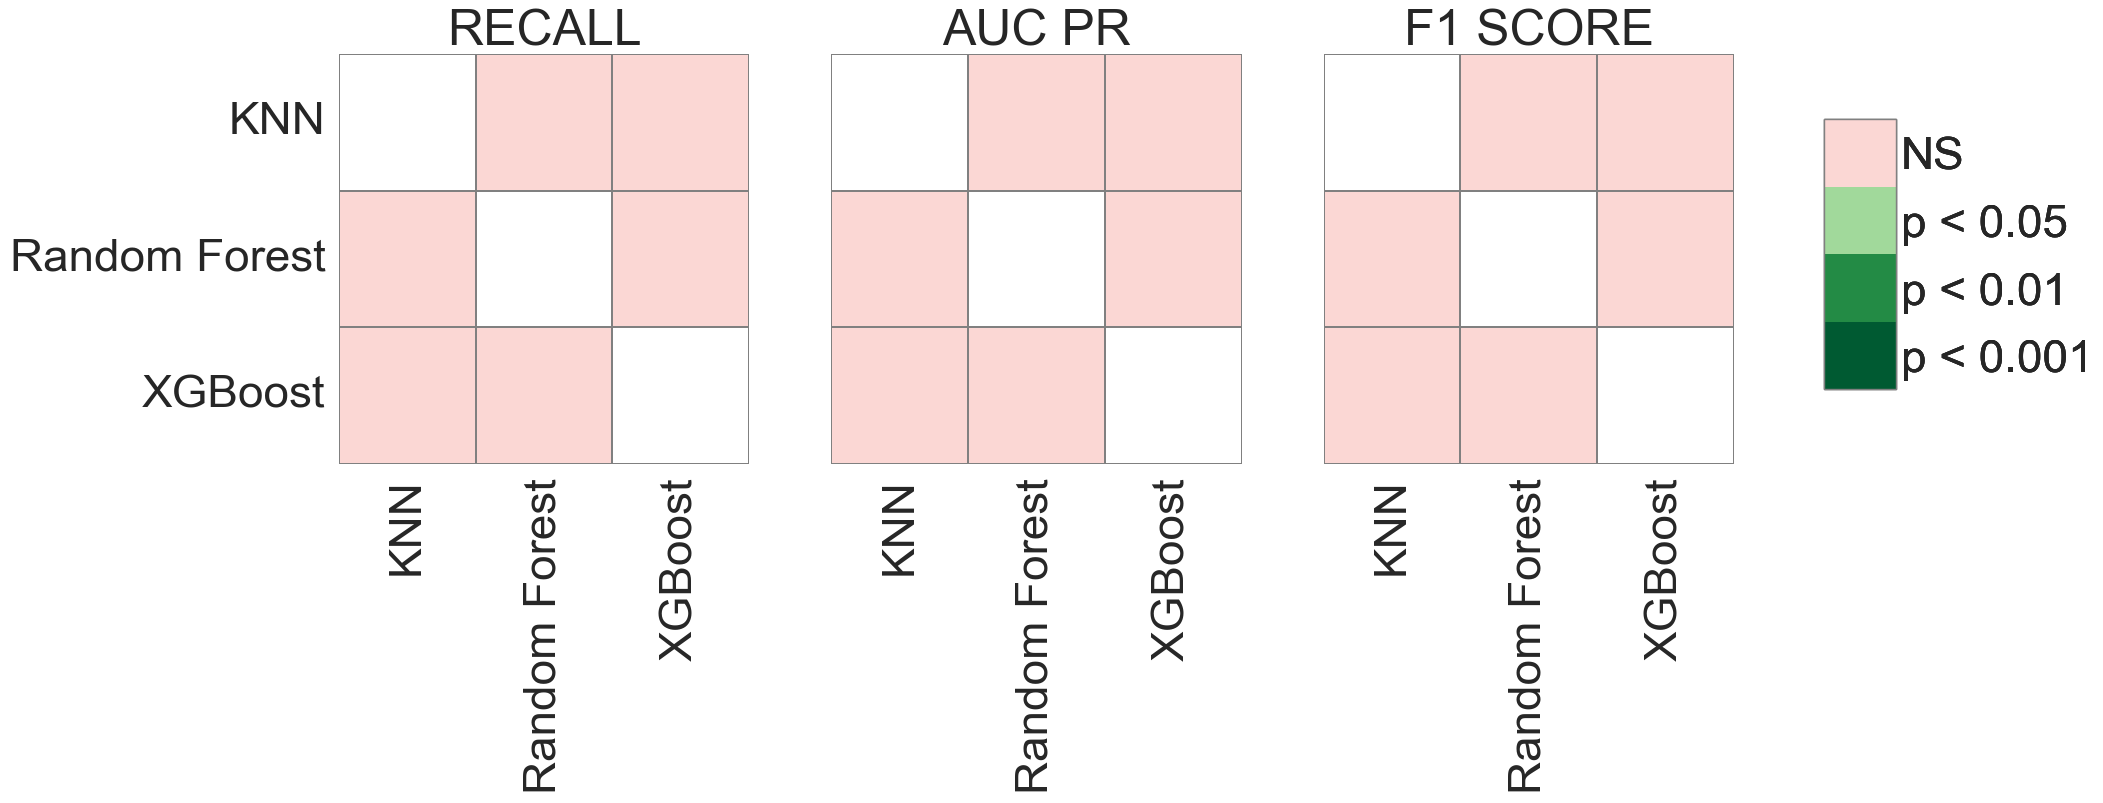

In [20]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp


x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

x = df_players_merged[x_var]
y = df_players_merged[y_var]

models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
    }

metrics_combined =  {'precision': [], 
     'recall': [], 
     'auc_pr': [], 
     'f1_score': []}

skf = StratifiedKFold(n_splits = 15)

def evaluate_model(model, x, y):
    precision_scores = []
    recall_scores = []
    auc_pr_scores = []
    f1_scores = []
    
    for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
        model.fit(x_train_fold, y_train_fold)
        y_true = y_test_fold
    
        y_pred = model.predict(x_test_fold)
        y_pred_proba = model.predict_proba(x_test_fold)[:, 1]
                
    
        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
        auc_pr_scores.append(average_precision_score(y_true, y_pred_proba))
        f1_scores.append(f1_score(y_true, y_pred))

    results = {
        'precision': precision_scores,
        'recall': recall_scores,
        'auc_pr': auc_pr_scores,
        'f1_score': f1_scores
    }
               
    return results
    
for model_name, model in models.items():
    scores = evaluate_model(model, x, y)
    for metric in scores:
        metrics_combined[metric].append(scores[metric])

sns.set(rc={'figure.figsize': (18, 9)}, font_scale = 3)
figure, axes = plt.subplots(1, 3, sharex = True, sharey= True)

i = 0

for name in metrics_combined:
    stat, p = friedmanchisquare(*metrics_combined[name])
    print(f'Friedman test for {name.capitalize()}: statistic={stat}, p-value={p}')
    
    if p < 0.05:
        df_scores = pd.DataFrame(metrics_combined[name]).T
        df_scores.columns = models.keys() 

        metrics_summary = df_scores.agg(['mean']).T
        print(f'\nMetrics Summary for {name.capitalize()} (p < 0.05):\n', metrics_summary)

        
        df_long = df_scores.melt(var_name='Model', value_name='Score')
        
        df = sp.posthoc_conover(df_long, group_col='Model', val_col='Score', p_adjust='holm')
        print(df)

        similarity_matrix = pd.DataFrame(df, index = models.keys())

        heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5',  'square': True}

        sub_ax, sub_c = sp.sign_plot(df, **heatmap_args, ax=axes[i])
        sub_ax.set_title(name.replace("_", " ").upper())
        i += 1
        if i >= 3:
            break

plt.show()


In [21]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

X = df_players_merged[x_var]
y = df_players_merged[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [22]:
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

scores = cross_validate(xgb_model, X, y, cv=5, scoring=scoring)

df = pd.DataFrame.from_dict(scores)

df.mean()

fit_time                  0.138220
score_time                0.026045
test_accuracy             0.981053
test_precision            0.953513
test_recall               0.940441
test_f1                   0.943008
test_average_precision    0.992086
dtype: float64

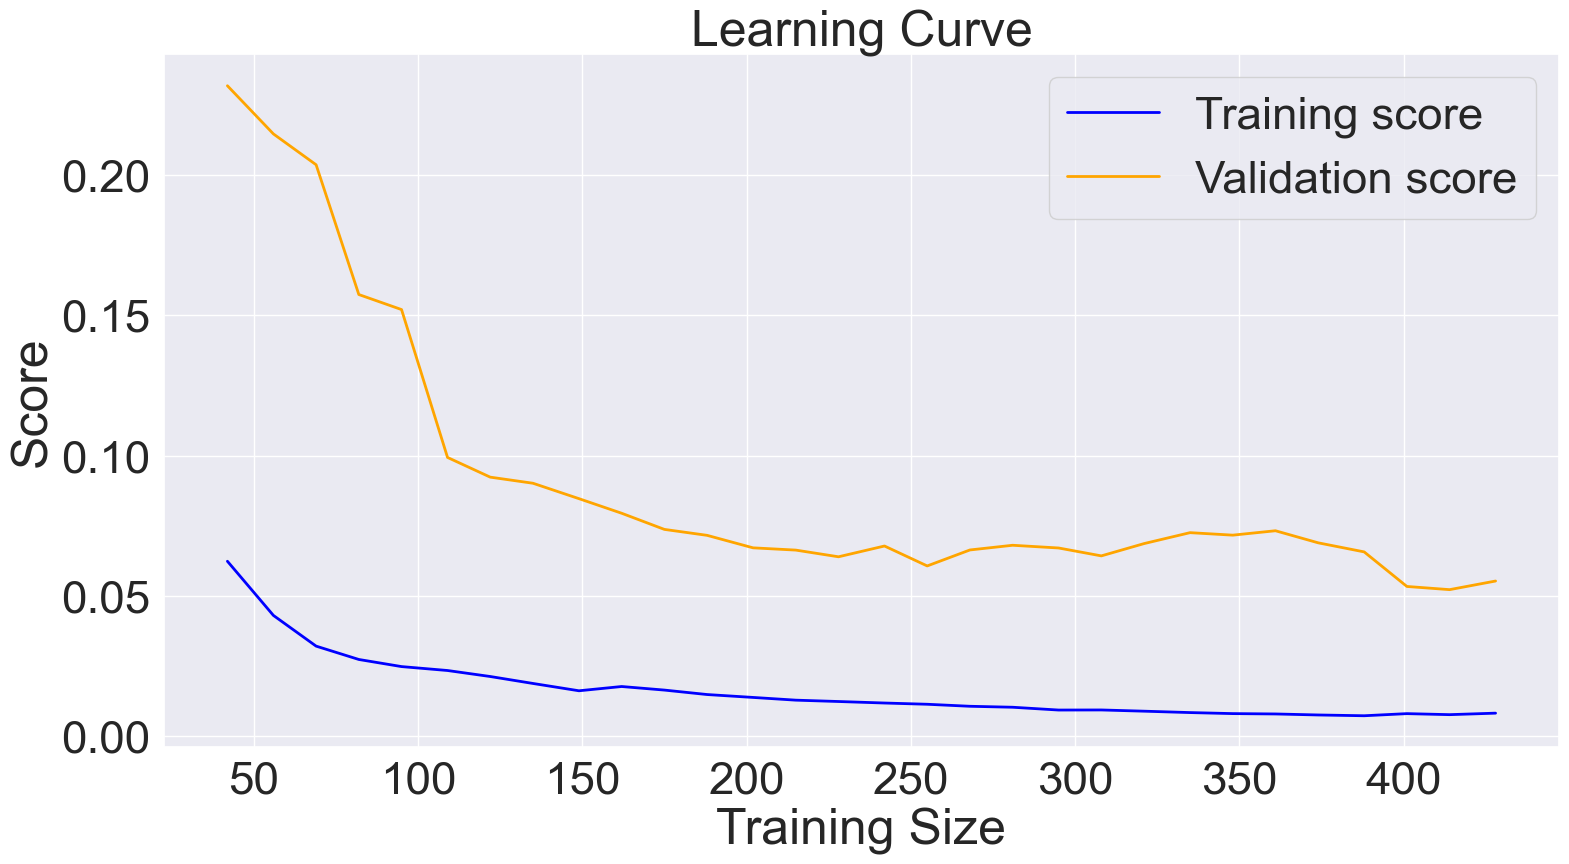

In [23]:
from sklearn.model_selection import learning_curve

cv = StratifiedKFold(n_splits=10)

train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y,
    train_sizes=np.linspace(0.1, 1, 30), 
    cv=cv, 
    scoring='neg_log_loss',  
    n_jobs=-1  
)

train_scores_mean = -np.mean(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
valid_scores_std = -np.std(valid_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', linewidth=2)
plt.plot(train_sizes, valid_scores_mean, label='Validation score', color='orange', linewidth=2)
plt.legend() 
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.show()

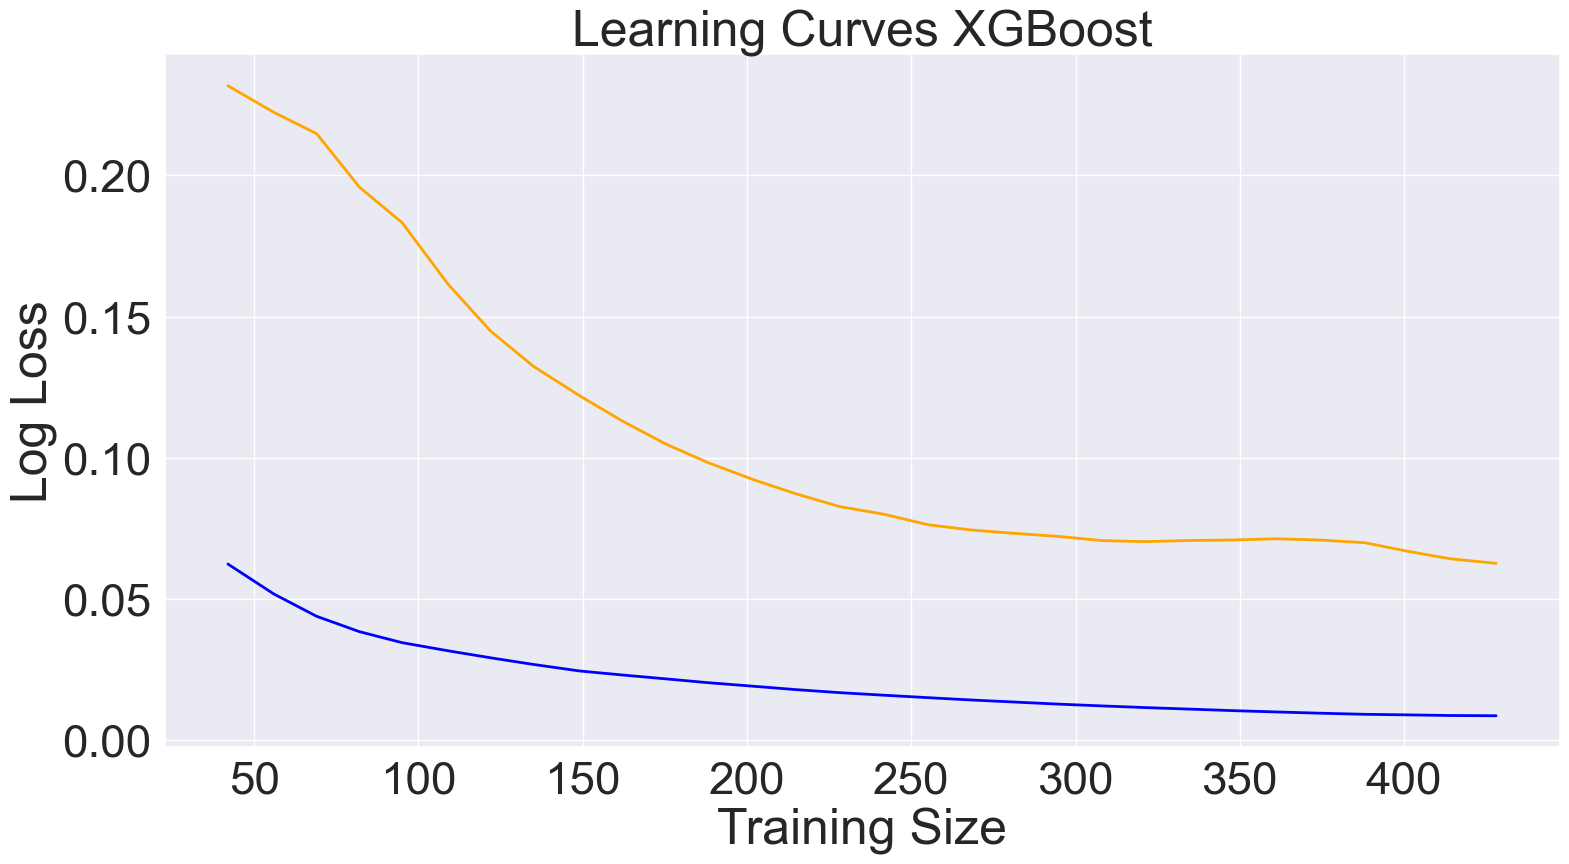

In [24]:
train_scores_smooth = pd.Series(train_scores_mean).ewm(span=10).mean()
valid_scores_smooth = pd.Series(valid_scores_mean).ewm(span=10).mean()

plt.plot(train_sizes, train_scores_smooth, label='Training score', color='blue', linewidth=2)
plt.plot(train_sizes, valid_scores_smooth, label='Cross-validation score', color='orange', linewidth=2)

plt.xlabel('Training Size')
plt.ylabel('Log Loss')
plt.title('Learning Curves XGBoost')
plt.show()

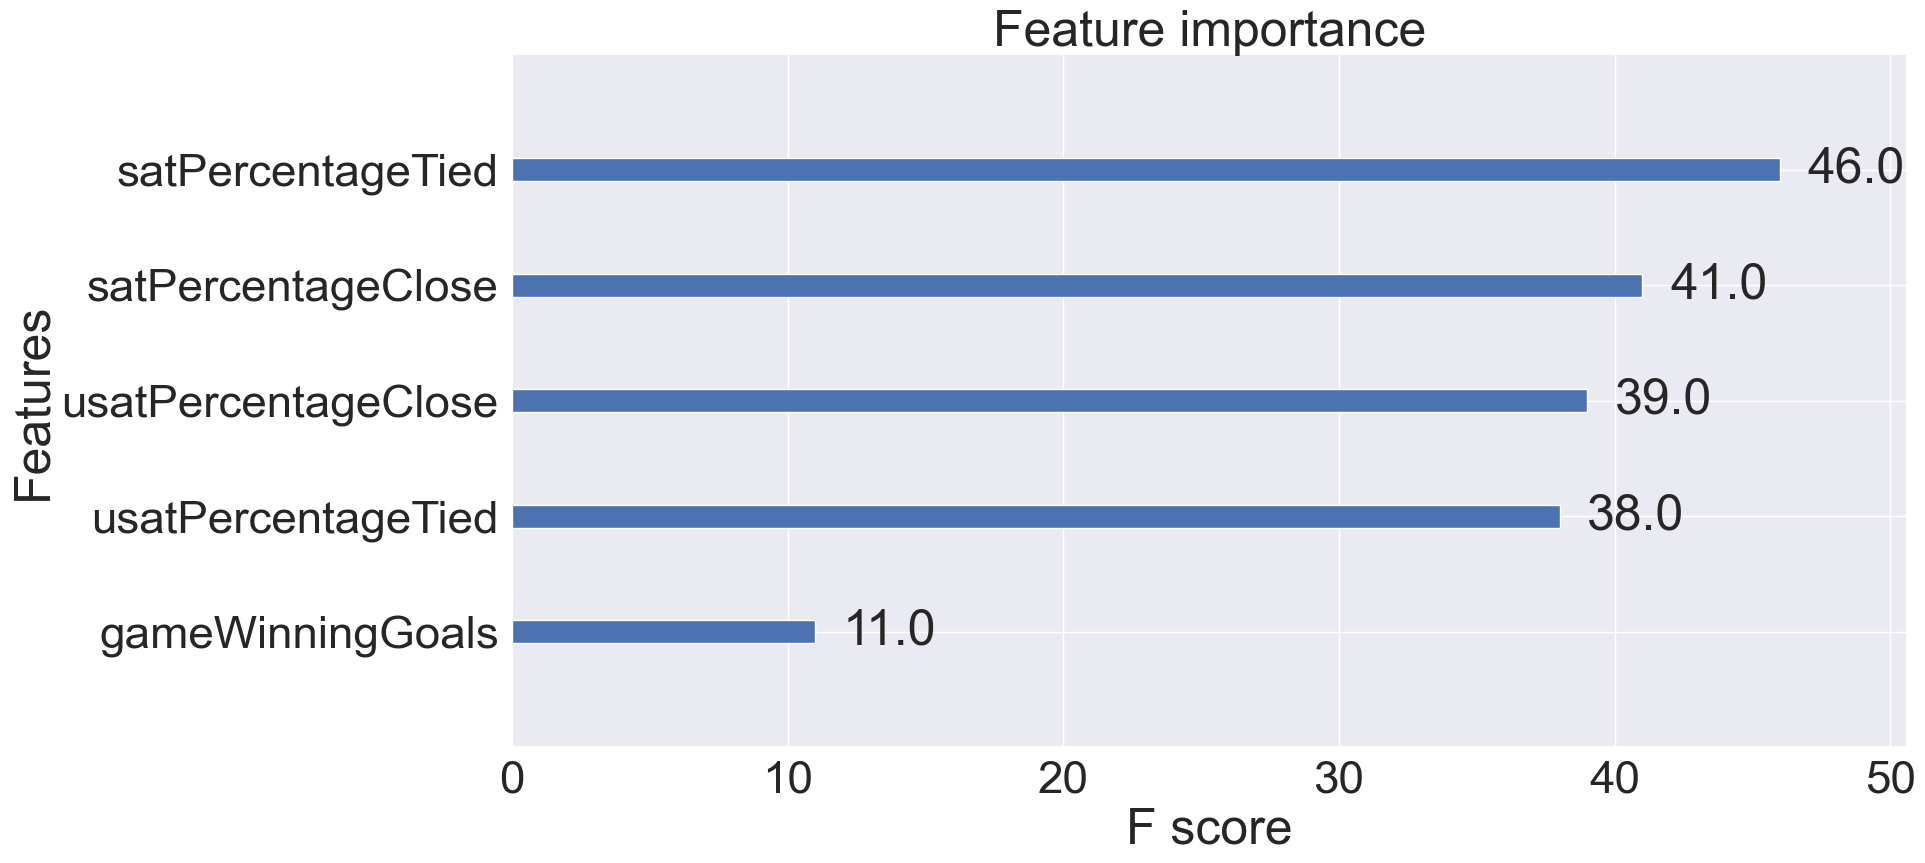

In [25]:
plot_importance(xgb_model)
plt.show()

In [26]:
x_var_adjusted = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageTied', 'satPercentageClose']
y_var = 'clutch_performance'

X_adjusted = df_players_merged[x_var_adjusted]
y = df_players_merged[y_var]

train_x, test_x, train_y, test_y = train_test_split(X_adjusted, y, test_size=0.2, random_state=50)

xgb_model_adjusted = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model_adjusted.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [27]:
from skopt import BayesSearchCV
import xgboost as xgb
import time
import math

scale_pos_weight = math.sqrt((df_players_merged['clutch_performance'] == 0).sum() / (df_players_merged['clutch_performance'] == 1).sum())

param_grid = {
    'max_depth': [1,3,5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.8] 
}

fit_params = {
'early_stopping_rounds': 15,
}


[0]	validation_0-logloss:0.44936	validation_1-logloss:0.47792
[1]	validation_0-logloss:0.39905	validation_1-logloss:0.42575
[2]	validation_0-logloss:0.35905	validation_1-logloss:0.38290
[3]	validation_0-logloss:0.32452	validation_1-logloss:0.34724
[4]	validation_0-logloss:0.29336	validation_1-logloss:0.31358
[5]	validation_0-logloss:0.26575	validation_1-logloss:0.28559
[6]	validation_0-logloss:0.24245	validation_1-logloss:0.26238
[7]	validation_0-logloss:0.22319	validation_1-logloss:0.24157
[8]	validation_0-logloss:0.20453	validation_1-logloss:0.22476
[9]	validation_0-logloss:0.18624	validation_1-logloss:0.20687
[10]	validation_0-logloss:0.17128	validation_1-logloss:0.19132
[11]	validation_0-logloss:0.15950	validation_1-logloss:0.17913
[12]	validation_0-logloss:0.14765	validation_1-logloss:0.16719
[13]	validation_0-logloss:0.13767	validation_1-logloss:0.15655
[14]	validation_0-logloss:0.12720	validation_1-logloss:0.14536
[15]	validation_0-logloss:0.11845	validation_1-logloss:0.13592
[1

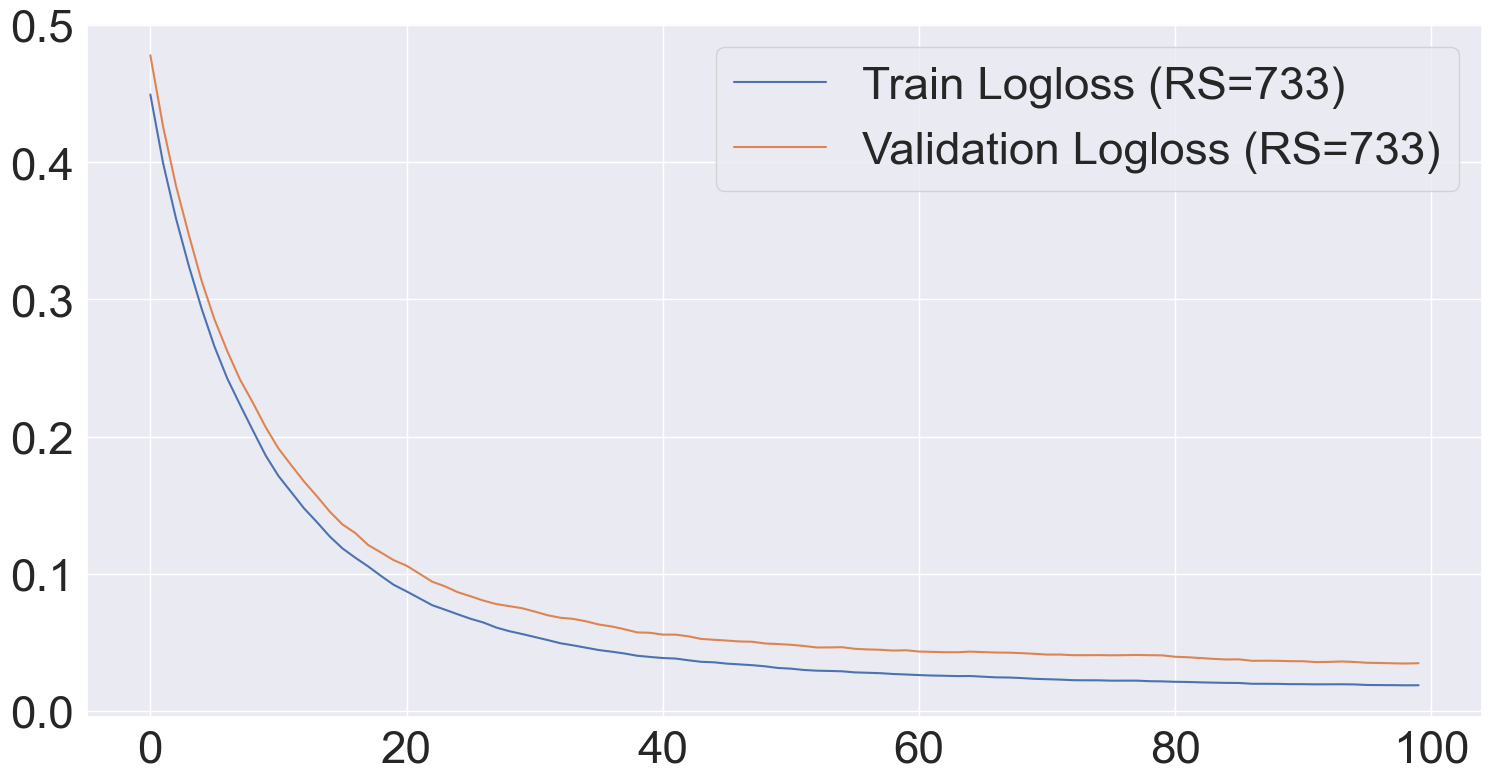

[0]	validation_0-logloss:0.34544	validation_1-logloss:0.36478
[1]	validation_0-logloss:0.25267	validation_1-logloss:0.26988
[2]	validation_0-logloss:0.19347	validation_1-logloss:0.20615
[3]	validation_0-logloss:0.15389	validation_1-logloss:0.16684
[4]	validation_0-logloss:0.12011	validation_1-logloss:0.13173
[5]	validation_0-logloss:0.10104	validation_1-logloss:0.11195
[6]	validation_0-logloss:0.08342	validation_1-logloss:0.09675
[7]	validation_0-logloss:0.06954	validation_1-logloss:0.08031
[8]	validation_0-logloss:0.05956	validation_1-logloss:0.07523
[9]	validation_0-logloss:0.04968	validation_1-logloss:0.06744
[10]	validation_0-logloss:0.04391	validation_1-logloss:0.05987
[11]	validation_0-logloss:0.03878	validation_1-logloss:0.05339
[12]	validation_0-logloss:0.03577	validation_1-logloss:0.05246
[13]	validation_0-logloss:0.03344	validation_1-logloss:0.05105
[14]	validation_0-logloss:0.03028	validation_1-logloss:0.04579
[15]	validation_0-logloss:0.02846	validation_1-logloss:0.04488
[1

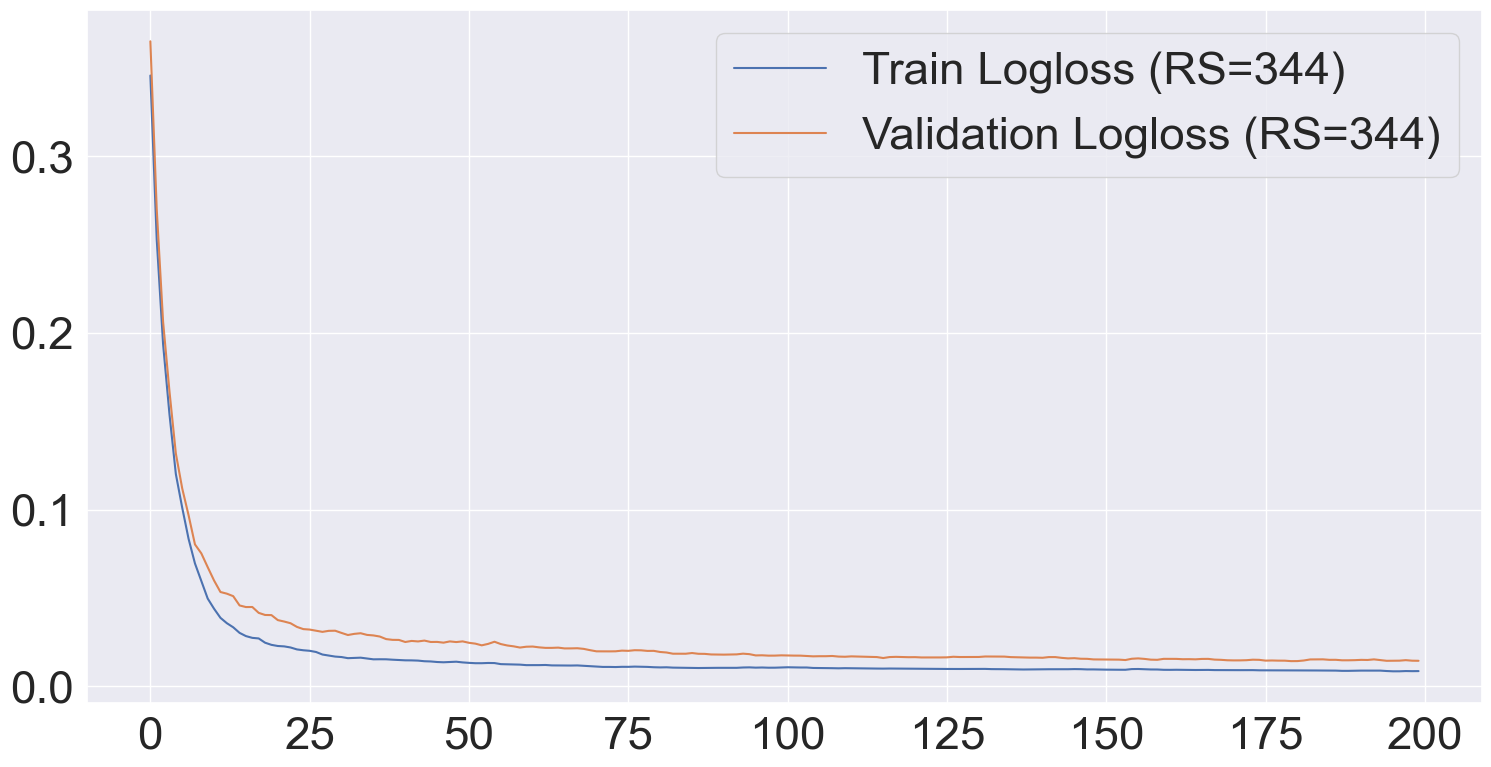

[0]	validation_0-logloss:0.34639	validation_1-logloss:0.36287
[1]	validation_0-logloss:0.25342	validation_1-logloss:0.26855
[2]	validation_0-logloss:0.19057	validation_1-logloss:0.20435
[3]	validation_0-logloss:0.14874	validation_1-logloss:0.16059
[4]	validation_0-logloss:0.11785	validation_1-logloss:0.13054
[5]	validation_0-logloss:0.09307	validation_1-logloss:0.10859
[6]	validation_0-logloss:0.07763	validation_1-logloss:0.09562
[7]	validation_0-logloss:0.06285	validation_1-logloss:0.08081
[8]	validation_0-logloss:0.05404	validation_1-logloss:0.07628
[9]	validation_0-logloss:0.04462	validation_1-logloss:0.06699
[10]	validation_0-logloss:0.03860	validation_1-logloss:0.05815
[11]	validation_0-logloss:0.03430	validation_1-logloss:0.05399
[12]	validation_0-logloss:0.03058	validation_1-logloss:0.05226
[13]	validation_0-logloss:0.02733	validation_1-logloss:0.04764
[14]	validation_0-logloss:0.02508	validation_1-logloss:0.04380
[15]	validation_0-logloss:0.02317	validation_1-logloss:0.04184
[1

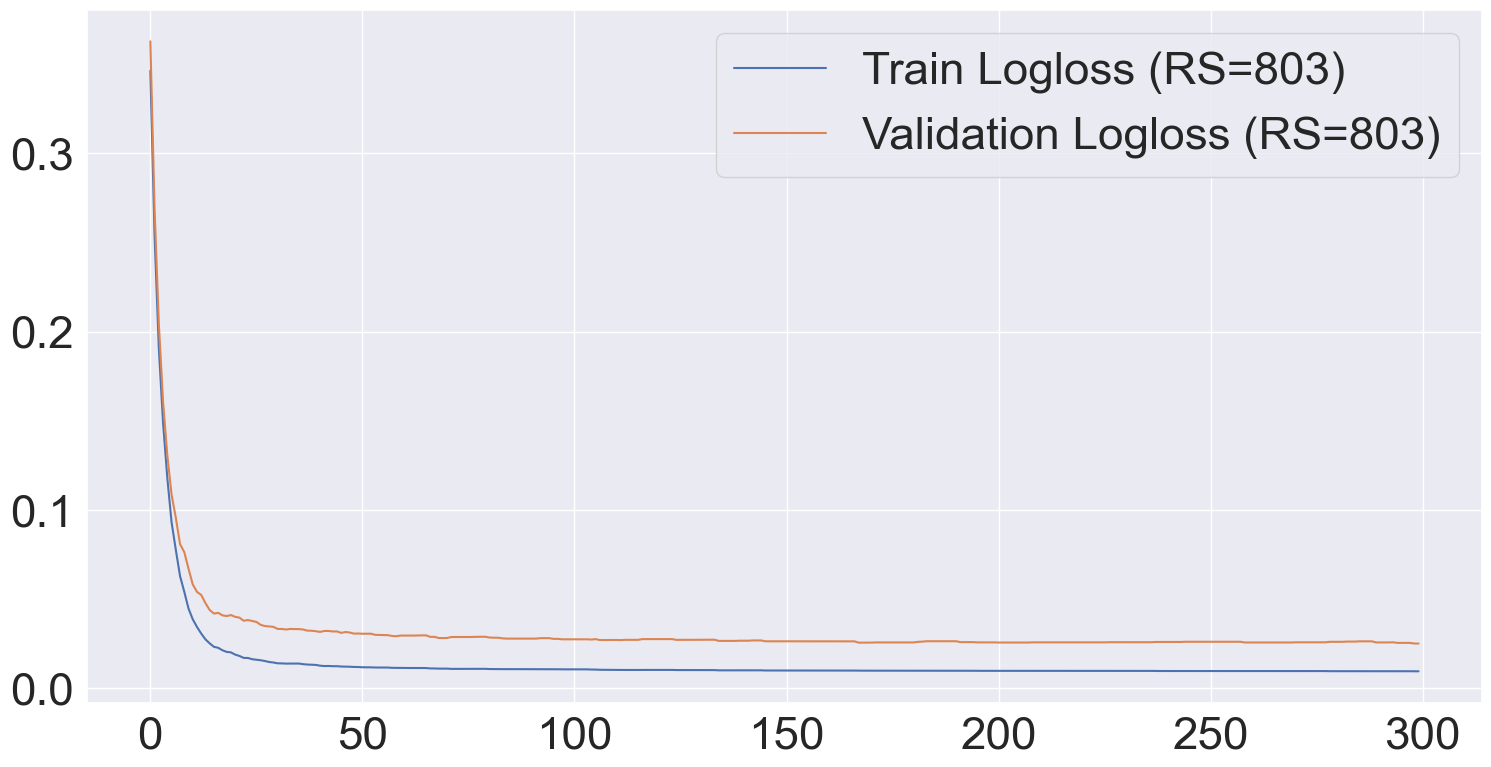

[0]	validation_0-logloss:0.22858	validation_1-logloss:0.24714
[1]	validation_0-logloss:0.13291	validation_1-logloss:0.14906
[2]	validation_0-logloss:0.08498	validation_1-logloss:0.09914
[3]	validation_0-logloss:0.05954	validation_1-logloss:0.07684
[4]	validation_0-logloss:0.04243	validation_1-logloss:0.05687
[5]	validation_0-logloss:0.03405	validation_1-logloss:0.05345
[6]	validation_0-logloss:0.02978	validation_1-logloss:0.05515
[7]	validation_0-logloss:0.02327	validation_1-logloss:0.04507
[8]	validation_0-logloss:0.02009	validation_1-logloss:0.04230
[9]	validation_0-logloss:0.01795	validation_1-logloss:0.04108
[10]	validation_0-logloss:0.01798	validation_1-logloss:0.03724
[11]	validation_0-logloss:0.01663	validation_1-logloss:0.03492
[12]	validation_0-logloss:0.01682	validation_1-logloss:0.03589
[13]	validation_0-logloss:0.01595	validation_1-logloss:0.03207
[14]	validation_0-logloss:0.01473	validation_1-logloss:0.02813
[15]	validation_0-logloss:0.01388	validation_1-logloss:0.02710
[1

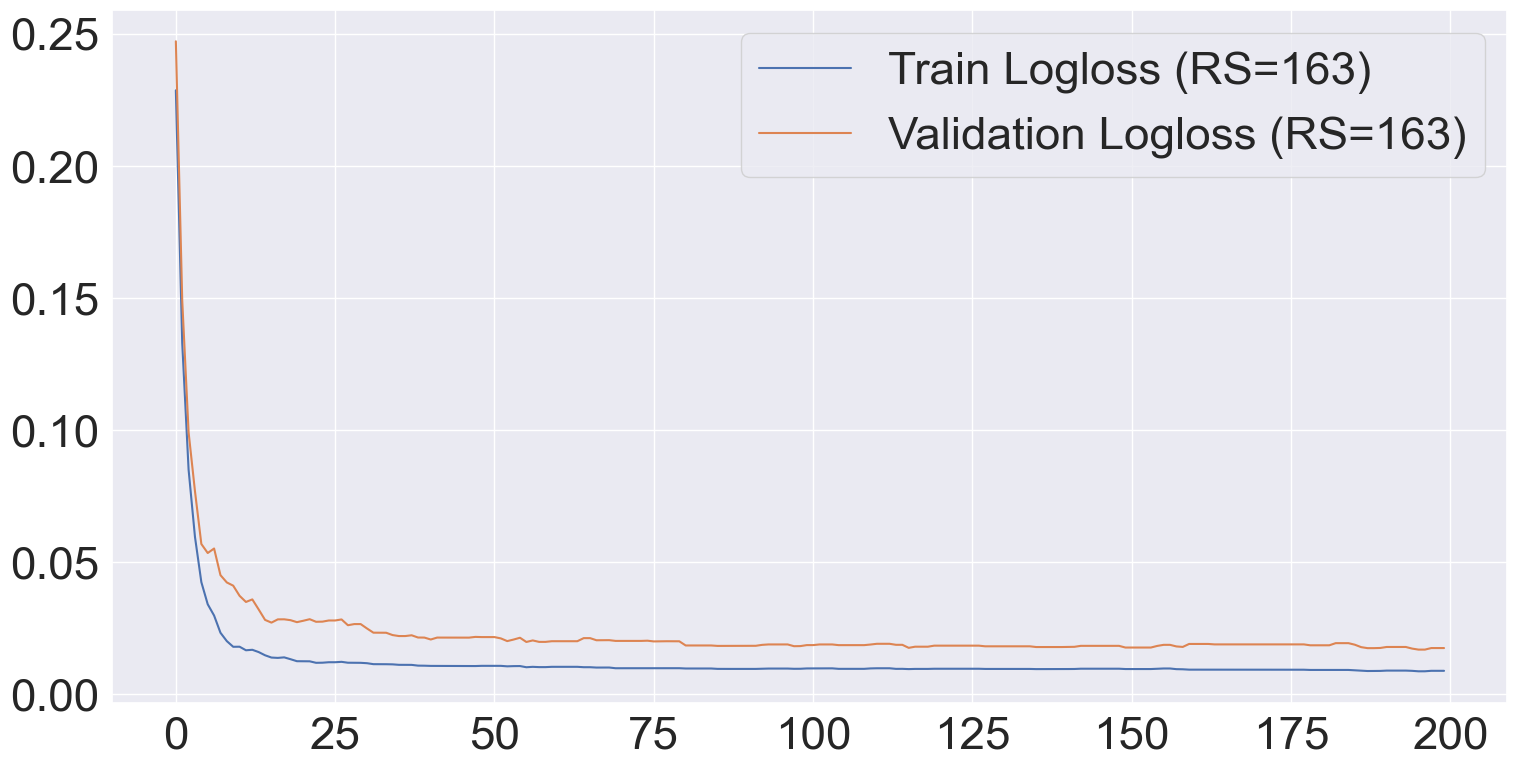

[0]	validation_0-logloss:0.46620	validation_1-logloss:0.49767
[1]	validation_0-logloss:0.42355	validation_1-logloss:0.45188
[2]	validation_0-logloss:0.38533	validation_1-logloss:0.41199
[3]	validation_0-logloss:0.35483	validation_1-logloss:0.37958
[4]	validation_0-logloss:0.33047	validation_1-logloss:0.35356
[5]	validation_0-logloss:0.30961	validation_1-logloss:0.33298
[6]	validation_0-logloss:0.28472	validation_1-logloss:0.30704
[7]	validation_0-logloss:0.26477	validation_1-logloss:0.28619
[8]	validation_0-logloss:0.24870	validation_1-logloss:0.27103
[9]	validation_0-logloss:0.23519	validation_1-logloss:0.25666
[10]	validation_0-logloss:0.22375	validation_1-logloss:0.24614
[11]	validation_0-logloss:0.21449	validation_1-logloss:0.23710
[12]	validation_0-logloss:0.20155	validation_1-logloss:0.22328
[13]	validation_0-logloss:0.19372	validation_1-logloss:0.21632
[14]	validation_0-logloss:0.18576	validation_1-logloss:0.20766
[15]	validation_0-logloss:0.17542	validation_1-logloss:0.19617
[1

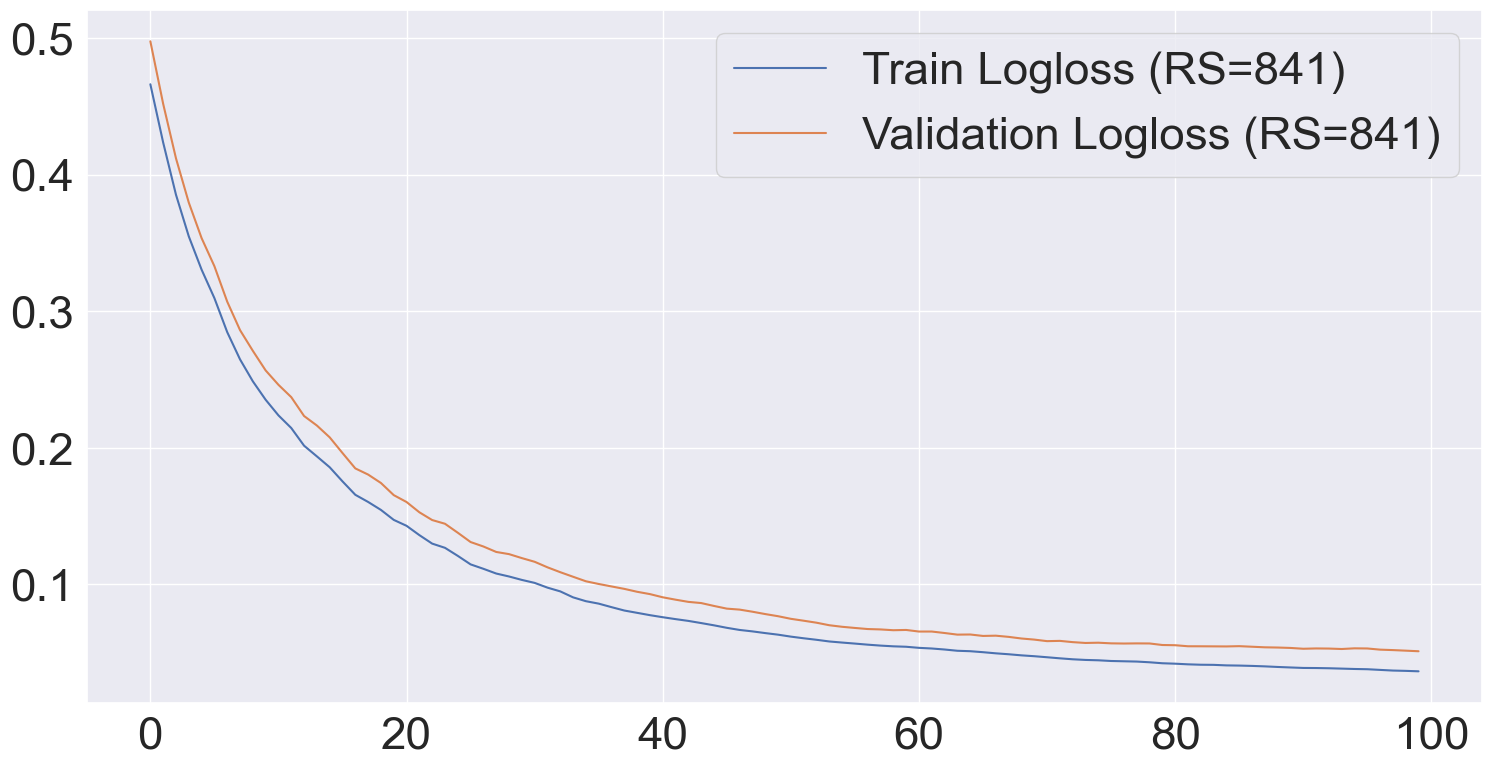

[0]	validation_0-logloss:0.44887	validation_1-logloss:0.47791
[1]	validation_0-logloss:0.39859	validation_1-logloss:0.42573
[2]	validation_0-logloss:0.35834	validation_1-logloss:0.38281
[3]	validation_0-logloss:0.32380	validation_1-logloss:0.34708
[4]	validation_0-logloss:0.29207	validation_1-logloss:0.31243
[5]	validation_0-logloss:0.26451	validation_1-logloss:0.28448
[6]	validation_0-logloss:0.24110	validation_1-logloss:0.26109
[7]	validation_0-logloss:0.22163	validation_1-logloss:0.24010
[8]	validation_0-logloss:0.20288	validation_1-logloss:0.22315
[9]	validation_0-logloss:0.18475	validation_1-logloss:0.20542
[10]	validation_0-logloss:0.16984	validation_1-logloss:0.18992
[11]	validation_0-logloss:0.15755	validation_1-logloss:0.17676
[12]	validation_0-logloss:0.14599	validation_1-logloss:0.16480
[13]	validation_0-logloss:0.13518	validation_1-logloss:0.15307
[14]	validation_0-logloss:0.12490	validation_1-logloss:0.14303
[15]	validation_0-logloss:0.11626	validation_1-logloss:0.13381
[1

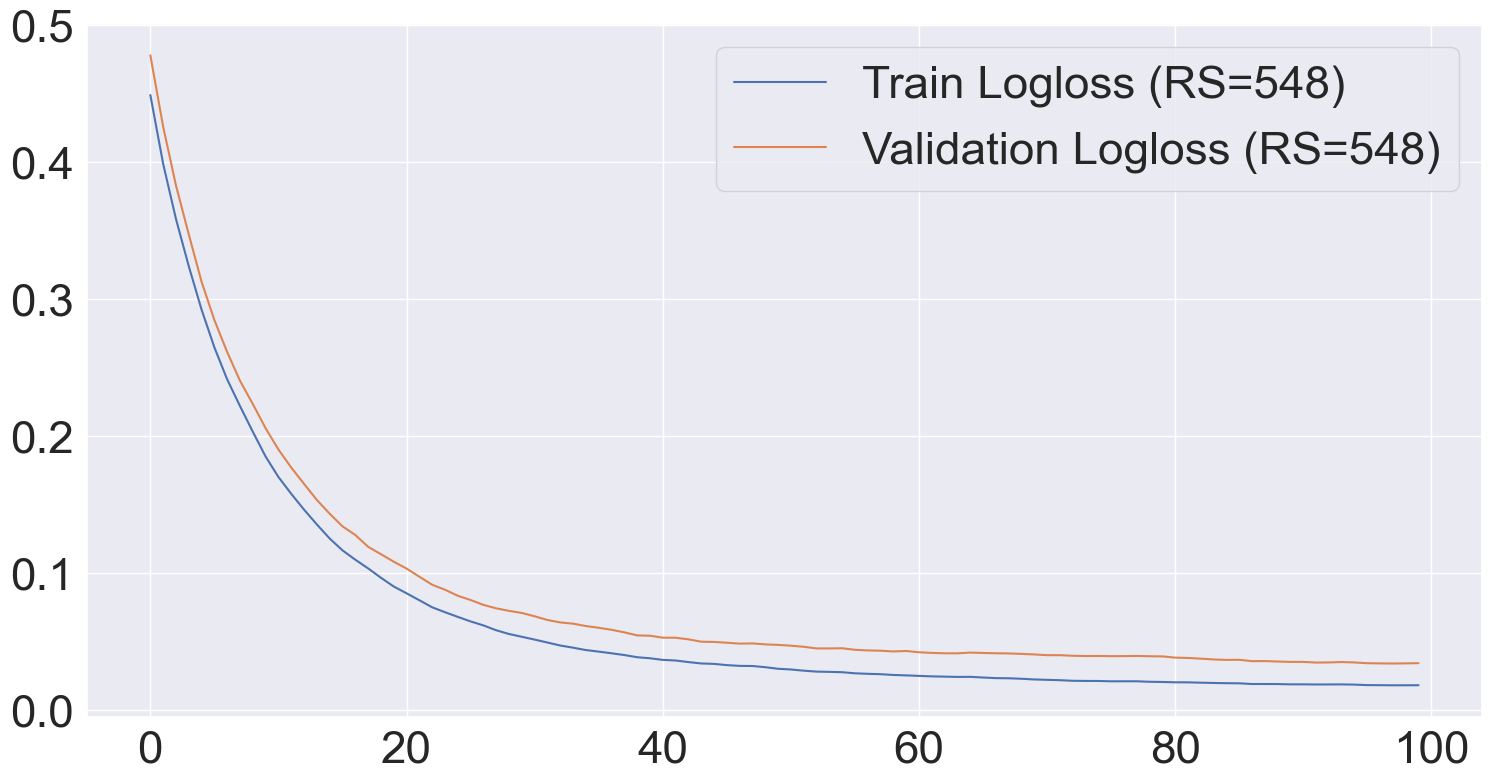

Average Accuracy: 0.9913194444444445
Average Precision: 0.961038961038961
Average Recall: 1.0
Average F1 Score: 0.9798683701122726
Averaged Hyperparameters:
colsample_bytree      0.716667
learning_rate         0.250000
max_depth             3.000000
min_child_weight      1.000000
n_estimators        166.666667
reg_alpha             0.833333
reg_lambda            0.850000
scale_pos_weight      2.192003
subsample             0.700000
dtype: float64


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb

cv = StratifiedKFold(n_splits=10)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
best_hyperparams_list = []

for _ in range(6):

    rs = np.random.randint(1, 1000)
    
    bayes_search = BayesSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter= 20, n_jobs=-1, random_state = rs, fit_params = fit_params)
    evalset = [(train_x, train_y), (test_x, test_y)]
    bayes_search.fit(X_adjusted, y, eval_set=evalset)

    xgb_best_model = bayes_search.best_estimator_
    results = xgb_best_model.evals_result()

    pyplot.plot(results['validation_0']['logloss'], label=f'Train Logloss (RS={rs})')
    pyplot.plot(results['validation_1']['logloss'], label=f'Validation Logloss (RS={rs})')

    pyplot.legend()
    pyplot.show()

    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)[:, 1]

    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)
    auc_pr = average_precision_score(y_true, y_pred_prob)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    best_hyperparams_list.append(bayes_search.best_params_)


print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))
print("Average F1 Score:", np.mean(f1_list))

hyperparams_df = pd.DataFrame(best_hyperparams_list)
averaged_hyperparams = hyperparams_df.mean()
print("Averaged Hyperparameters:")
print(averaged_hyperparams)

In [31]:
from sklearn.model_selection import permutation_test_score

score, permutation_scores, pvalue = permutation_test_score(xgb_model_adjusted, X_adjusted, y)


In [32]:
pvalue

0.009900990099009901

In [33]:
from sklearn.model_selection import permutation_test_score

score, permutation_scores, pvalue = permutation_test_score(xgb_model_adjusted, X_adjusted, y, scoring = 'recall')

In [34]:
pvalue

0.009900990099009901

In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score

xgb_best_model = bayes_search.best_estimator_

y_true = test_y 

y_pred = xgb_best_model.predict(test_x[x_var_adjusted])
y_pred_prob = xgb_best_model.predict_proba(test_x[x_var_adjusted])[:, 1]  

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_pr = average_precision_score(y_true, y_pred_prob)

print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("F1 Score:", round(f1, 2))
print("AUC PR:", round(auc_pr, 2))


Accuracy: 0.99
Precision: 0.93
Recall: 1.0
F1 Score: 0.96
AUC PR: 1.0


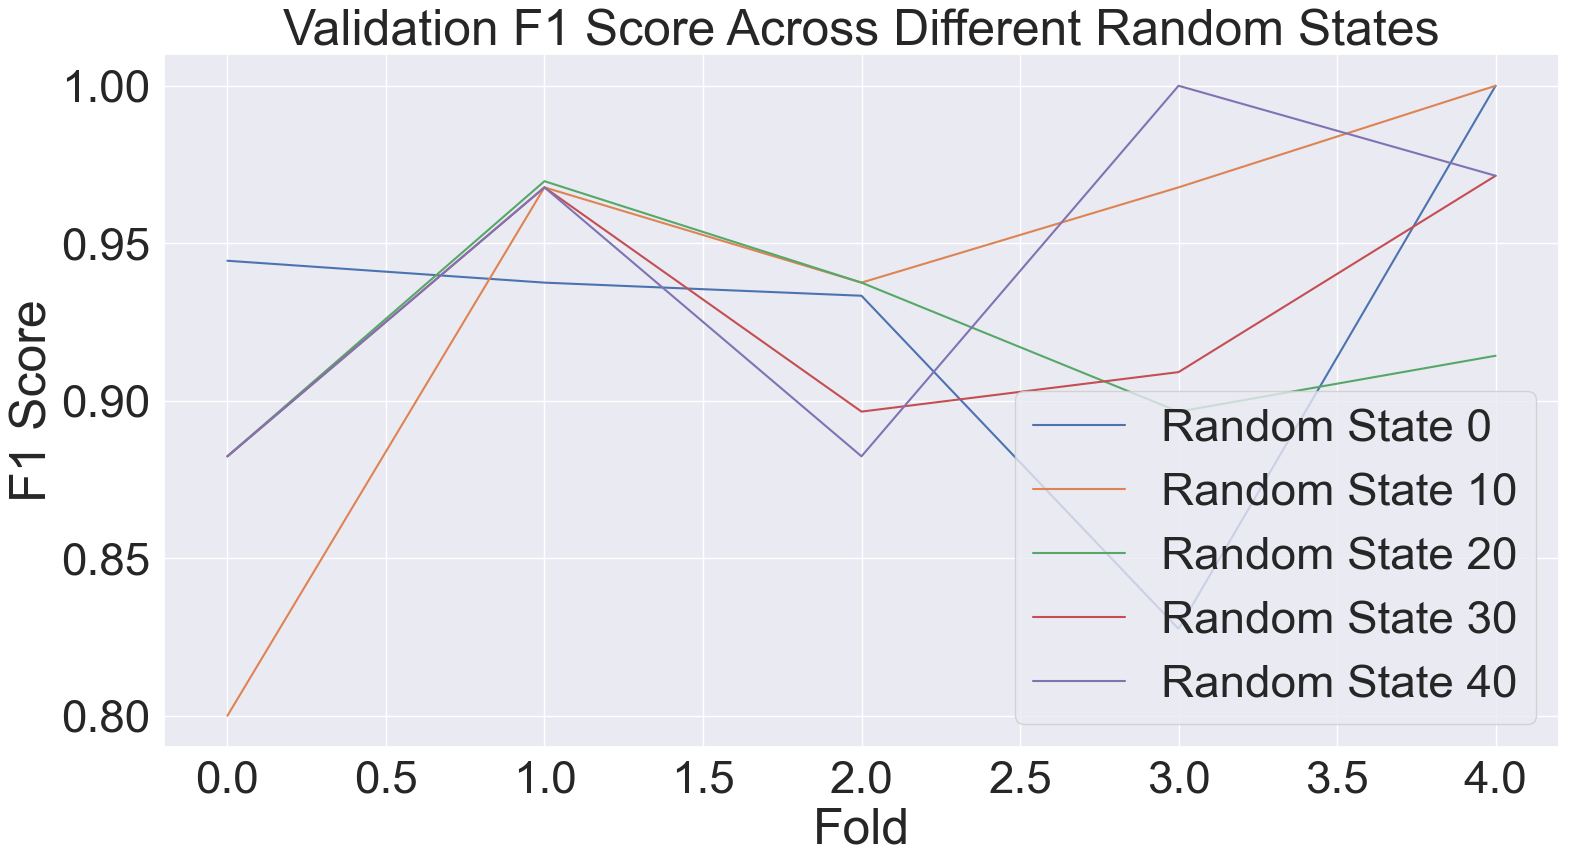

In [69]:
import matplotlib.pyplot as plt

random_states = [0, 10, 20, 30, 40]
for rs in random_states:
    train_scores = []
    val_scores = []
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)
    for train_idx, val_idx in cv.split(X, y):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
        model.fit(train_x, train_y)
        
        train_pred = model.predict(train_x)
        val_pred = model.predict(val_x)
        
        train_scores.append(f1_score(train_y, train_pred))
        val_scores.append(f1_score(val_y, val_pred))

    plt.plot(val_scores, label=f'Random State {rs}')
    
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score Across Different Random States')
plt.legend()
plt.show()


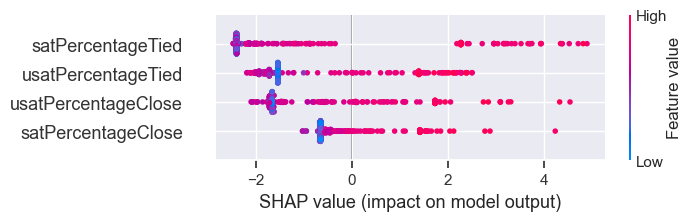

In [67]:
import shap

explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(train_xgb[x_var_adjusted])

shap.summary_plot(shap_values, train_xgb[x_var_adjusted])

In [42]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], train_xgb[x_var_adjusted].iloc[0])

NameError: name 'shap' is not defined

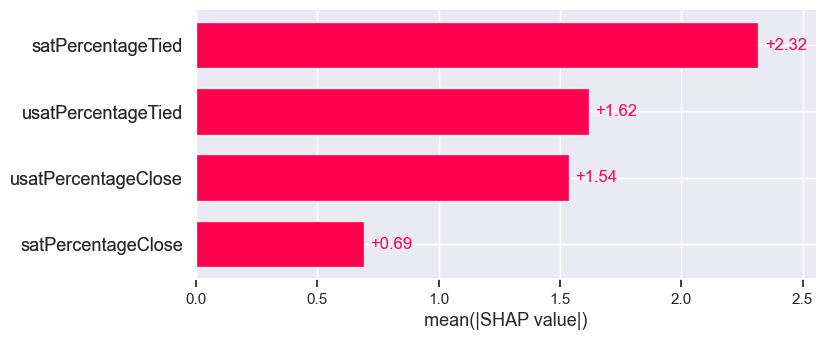

In [73]:
shap.plots.bar(shap_values)

In [102]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

train_xgb, test_xgb = train_test_split(random_sample, test_size=0.2, random_state=42)

evalset = [(train_xgb[x_var_adjusted], train_xgb[y_var]), (test_xgb[x_var_adjusted], test_xgb[y_var])]

xgb_best_model.fit(train_xgb[x_var_adjusted], train_xgb[y_var], eval_set=evalset, verbose=True)

y_pred_final = xgb_best_model.predict(test_xgb[x_var_adjusted])
y_pred_prob_final = xgb_best_model.predict_proba(test_xgb[x_var_adjusted])[:, 1]

[0]	validation_0-logloss:0.56224	validation_1-logloss:0.56961
[1]	validation_0-logloss:0.50006	validation_1-logloss:0.50637
[2]	validation_0-logloss:0.44693	validation_1-logloss:0.45241
[3]	validation_0-logloss:0.40412	validation_1-logloss:0.41778
[4]	validation_0-logloss:0.36397	validation_1-logloss:0.37638
[5]	validation_0-logloss:0.32892	validation_1-logloss:0.34022
[6]	validation_0-logloss:0.29815	validation_1-logloss:0.30847
[7]	validation_0-logloss:0.27102	validation_1-logloss:0.28047
[8]	validation_0-logloss:0.24892	validation_1-logloss:0.26310
[9]	validation_0-logloss:0.22739	validation_1-logloss:0.24049
[10]	validation_0-logloss:0.20823	validation_1-logloss:0.22035
[11]	validation_0-logloss:0.19113	validation_1-logloss:0.20236
[12]	validation_0-logloss:0.17583	validation_1-logloss:0.18625
[13]	validation_0-logloss:0.16210	validation_1-logloss:0.17179
[14]	validation_0-logloss:0.14977	validation_1-logloss:0.15879
[15]	validation_0-logloss:0.13868	validation_1-logloss:0.14708
[1

In [103]:
y_true = test_xgb[y_var]
y_pred = xgb_best_model.predict(test_xgb[x_var_adjusted])
y_pred_prob = xgb_best_model.predict_proba(test_xgb[x_var_adjusted])[:, 1]  

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

auc_pr = average_precision_score(y_true, y_pred_prob)

print("Accuracy:", round(accuracy,2))
print("Precision:", round(precision,2))
print("Recall:", round(recall,2))
print("F1 Score:", round(f1,2))
print("AUC PR:", round(auc_pr,2))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC PR: 1.0


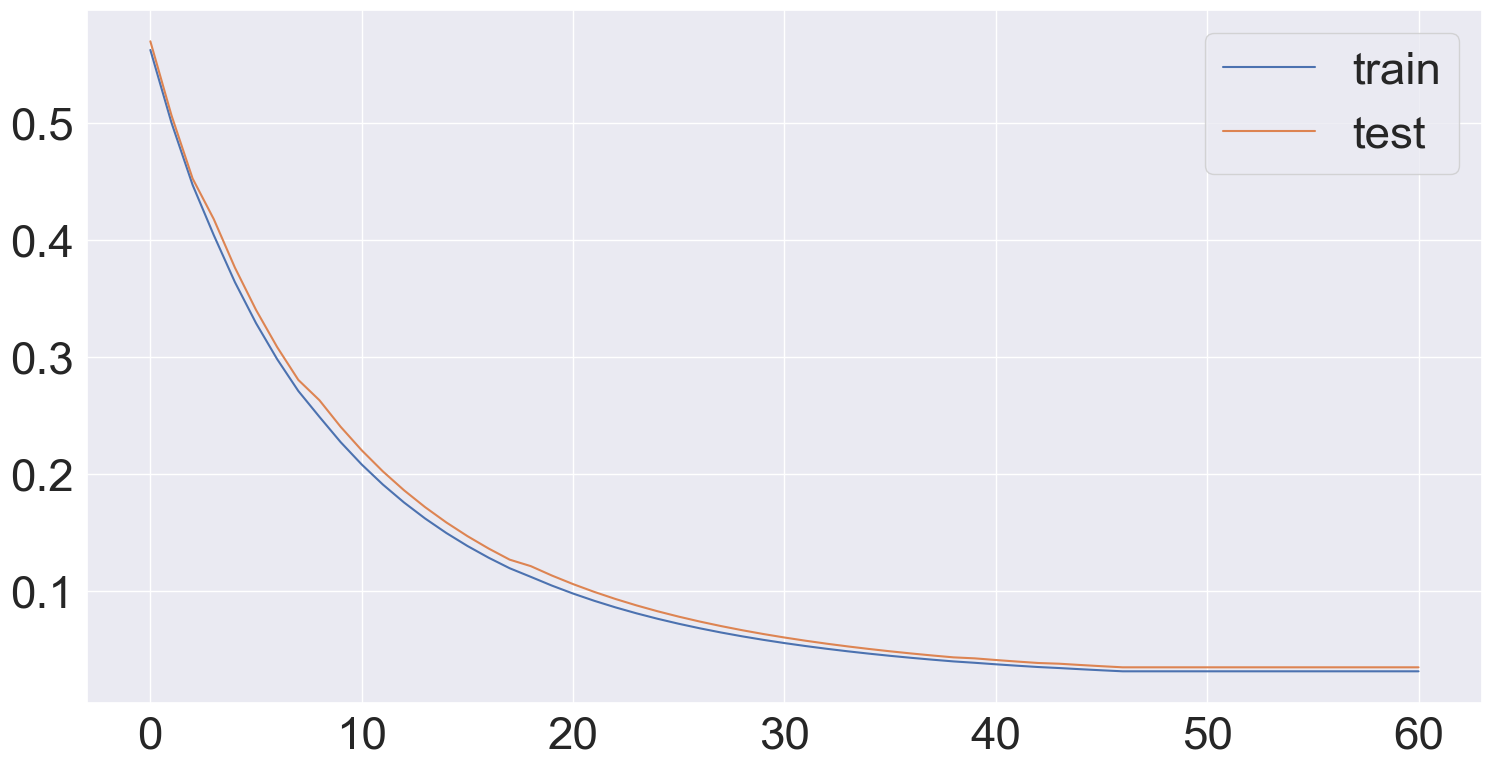

In [104]:
results = xgb_best_model.evals_result()

pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
pyplot.legend()
pyplot.show()

In [171]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score

# Step 1: Use the best model to make predictions on the test set
y_true = df_test['clutch_performance']  # True labels from the test set
y_pred = xgb_best_model.predict(df_test[x_var_adjusted])  # Make predictions

# Step 2: Calculate performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_pr = average_precision_score(y_true, xgb_best_model.predict_proba(df_test[x_var_adjusted])[:, 1])  # AUC-PR

# Step 3: Print the results
print("Test Set Metrics:")
print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("F1 Score:", round(f1, 2))
print("AUC PR:", round(auc_pr, 2))

Test Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC PR: 1.0


In [33]:
xgb_model.fit(train_xgb[x_var_adjusted], train_xgb[y_var])

y_train_pred = xgb_model.predict(train_xgb[x_var_adjusted])

y_test_pred = xgb_model.predict(test_xgb[x_var_adjusted])

train_accuracy = accuracy_score(train_xgb[y_var], y_train_pred)
train_precision = precision_score(train_xgb[y_var], y_train_pred)
train_recall = recall_score(train_xgb[y_var], y_train_pred)
train_f1 = f1_score(train_xgb[y_var], y_train_pred)

# Print results
print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy:.2f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}")


Training Set Metrics:
Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


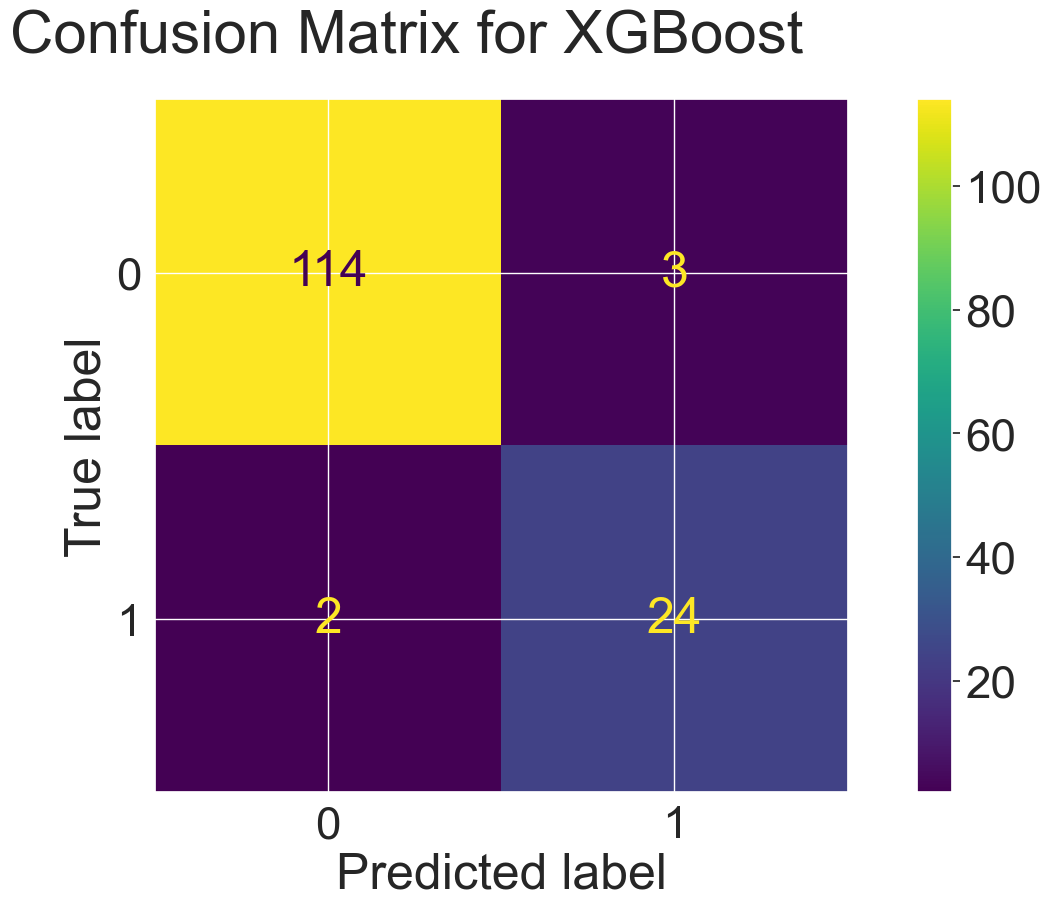

In [160]:
conf_matrix = confusion_matrix(y_pred_xgb, y_true_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [156]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = ['clutch_performance']
train, test = train_test_split(df_players_merged, test_size = 0.3)

random_forest_model = RandomForestClassifier(n_estimators=100)
random_forest_model.fit(train[x_var], train[y_var].values.ravel())

RandomForestClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

x_var_adjusted = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageTied']
y_var = 'clutch_performance'

scale_pos_weight = (df_players_merged['clutch_performance'] == 0).sum() / (df_players_merged['clutch_performance'] == 1).sum()

param_grid = {
    'max_depth': [1, 3, 5, 7],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda':[0.1, 0.5, 1.0]
    
}

random_search = RandomizedSearchCV(estimator = xgb_model, param_distributions = param_grid, cv = 5, n_jobs = -1,n_iter=100)

start_time = time.time()
random_search.fit(train_xgb[x_var_adjusted], train_xgb[y_var])
xgb_duration = time.time() - start_time

print("Best Parameters:", random_search.best_params_)
print ("Time: ", xgb_duration)

In [97]:
scores = cross_val_score(xgb_model, df_players_merged[x_var], df_players_merged[y_var].values.ravel(), cv=10)
scores

array([1.        , 0.97916667, 0.95833333, 1.        , 0.97916667,
       0.95833333, 0.9787234 , 1.        , 1.        , 0.95744681])

In [98]:
scores.mean()

0.9811170212765958

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 0.65, 'scale_pos_weight': 4.804878048780488, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.75}
Best Balanced Accuracy: 0.9749943039416724


In [101]:
best_model = random_search.best_estimator_
best_model.fit(train[x_var], train[y_var])

accuracy = best_model.score(test[x_var], test[y_var])
print("Accuracy:", accuracy)

Accuracy: 0.9440559440559441


In [102]:
cv_scores = cross_val_score(best_model, df_players_merged[x_var], df_players_merged[y_var], cv=10)

cv_scores

array([0.9375    , 0.97916667, 0.95833333, 0.97916667, 0.97916667,
       0.97916667, 0.95744681, 1.        , 0.9787234 , 0.95744681])

In [103]:
cv_scores.mean()

0.9706117021276597

In [104]:
y_pred = best_model.predict(test[x_var])  
y_true = test[y_var]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8055555555555556
Recall: 0.9666666666666667
F1 Score: 0.8787878787878789


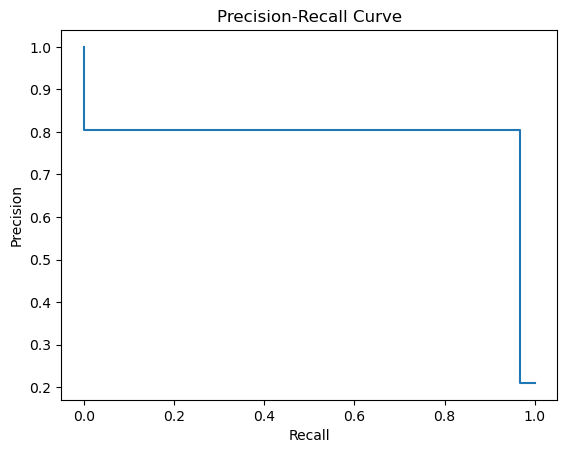

In [105]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

display = PrecisionRecallDisplay(precision=precision, recall=recall)

display.plot()

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")

plt.show()

In [107]:
probability = best_model.predict_proba(test[x_var])[:, 1]

auc_pr = average_precision_score(test[y_var], probability)

auc_pr

0.9817724867724869

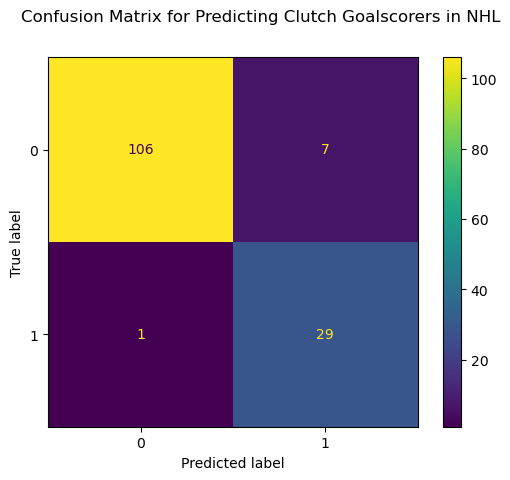

In [108]:
conf_matrix = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for Predicting Clutch Goalscorers in NHL')
plt.show()

In [109]:
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
accuracy

0.9440559440559441

In [110]:
df_players_merged['gameWinningGoalsPercentile'] = df_players_merged['gameWinningGoalsPercentile'].astype(str) + '%'
df_players_merged['tiedPercentile'] = df_players_merged['tiedPercentile'].astype(str) + '%'
df_players_merged['closePercentile'] = df_players_merged['closePercentile'].astype(str) + '%'
df_players_merged['final'] = df_players_merged['final'].astype(str) + '%'

In [111]:
df_players_merged.to_csv(r'C:\Users\shakj\Desktop\nhl_clutch_player_data1.csv', index=False)

In [112]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,...,satPercentageClosePercentile,satPercentageTiedPercentile,usatPercentageTiedPercentile,usatPercentageClosePercentile,gameWinningGoalsPercentile,tiedPercentile,closePercentile,final,finalRank,clutch_performance
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,46.4,43.6,40.1,...,27.94,15.13,3.99,13.76,36.97%,9.56%,20.85%,23.91%,399.0,0
1,8475763,Kevin Hayes,Hayes,R,STL,79,L,45.0,44.3,43.0,...,20.48,18.28,13.76,13.76,55.67%,16.02%,17.12%,32.21%,355.0,0
2,8471698,T.J. Oshie,Oshie,R,WSH,56,R,43.3,41.6,41.1,...,12.82,8.61,7.25,11.55,80.78%,7.93%,12.18%,38.35%,320.0,0
3,8482259,Bobby McMann,McMann,C,TOR,56,L,52.3,51.8,50.9,...,72.90,67.65,59.56,78.36,13.34%,63.6%,75.63%,47.1%,267.0,0
4,8480748,Kiefer Sherwood,Sherwood,L,NSH,74,R,52.0,53.5,53.4,...,70.38,78.26,76.16,70.80,55.67%,77.21%,70.59%,66.61%,123.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8474870,Tyler Johnson,Johnson,C,CHI,67,R,37.4,37.3,37.7,...,1.16,1.68,2.31,0.84,36.97%,2.0%,1.0%,15.69%,438.0,0
472,8475913,Mark Stone,Stone,R,VGK,63,R,45.5,43.1,42.1,...,21.85,13.34,10.82,20.80,87.82%,12.08%,21.33%,45.15%,281.0,0
473,8478831,Kevin Stenlund,Stenlund,C,FLA,105,R,48.8,51.1,48.8,...,44.33,61.03,43.70,33.82,70.17%,52.36%,39.08%,55.5%,207.0,0
474,8476483,Rickard Rakell,Rakell,R,PIT,70,R,52.7,52.8,52.5,...,76.05,74.16,71.64,66.49,55.67%,72.9%,71.27%,65.52%,130.0,0


In [113]:
df_players_merged['finalRank'] = df_players_merged['finalRank'].astype(int)

df_players_merged.rename(columns={'skaterFullName': 'Name', 'closePercentile': 'Close Percentile', 'tiedPercentile': 'Tied Percentile', 'closePercentile': 'Close Percentile', 'gameWinningGoalsPercentile': 'GWG Percentile', 'final': 'Clutch Percentile','finalRank': 'Rank'}, inplace=True)

df_players_merged[['Name', 'Close Percentile',  'Tied Percentile', 'Clutch Percentile', 'GWG Percentile', 'Rank']].sort_values('Rank', ascending=True).head(5)

,Name,Close Percentile,Tied Percentile,Clutch Percentile,GWG Percentile,Rank
399,Zach Hyman,97.0%,97.38%,97.73%,98.53%,1
188,Sebastian Aho,96.96%,96.12%,97.63%,99.26%,2
12,Seth Jarvis,96.64%,97.38%,97.2%,97.48%,3
252,Andrei Svechnikov,98.37%,94.02%,96.12%,96.01%,4
194,Sam Reinhart,93.48%,93.49%,96.09%,100.0%,5


In [114]:
df_players_merged[['Name', 'Close Percentile',  'Tied Percentile', 'GWG Percentile', 'Clutch Percentile', 'Rank']].sort_values('Rank', ascending=True).head(10)

,Name,Close Percentile,Tied Percentile,GWG Percentile,Clutch Percentile,Rank
399,Zach Hyman,97.0%,97.38%,98.53%,97.73%,1
188,Sebastian Aho,96.96%,96.12%,99.26%,97.63%,2
12,Seth Jarvis,96.64%,97.38%,97.48%,97.2%,3
252,Andrei Svechnikov,98.37%,94.02%,96.01%,96.12%,4
194,Sam Reinhart,93.48%,93.49%,100.0%,96.09%,5
338,Nathan MacKinnon,95.32%,93.65%,97.48%,95.68%,6
110,Aleksander Barkov,94.54%,94.7%,96.01%,95.18%,7
166,Mikko Rantanen,93.38%,91.23%,98.53%,94.8%,8
87,Connor McDavid,97.84%,95.28%,91.6%,94.58%,9
397,Artemi Panarin,90.44%,90.18%,97.48%,93.18%,10
